In [65]:
import pathlib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("PROJECT_DIR", PROJECT_DIR := pathlib.Path.cwd().parent)
print("DATA_DIR", DATA_DIR := PROJECT_DIR / "data")

PROJECT_DIR /home/uzunb/Projects/municipality-bus-utilization-forecasting
DATA_DIR /home/uzunb/Projects/municipality-bus-utilization-forecasting/data


In [66]:
def mean_absolute_percentage_error(y_true, y_pred):
    """  Mean Absolute Percentage Error - MAPE """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [67]:
# Read the data
df = pd.read_csv(DATA_DIR / 'municipality_bus_utilization.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('timestamp')
df

,municipality_id,usage,total_capacity
timestamp,,,
2017-06-04 07:59:42,9,454,1332
2017-06-04 07:59:42,8,556,2947
2017-06-04 07:59:42,4,1090,3893
2017-06-04 07:59:42,0,204,2813
2017-06-04 07:59:42,7,718,2019
...,...,...,...
2017-08-19 16:30:35,2,548,697
2017-08-19 16:30:35,8,1193,2947
2017-08-19 16:30:35,7,1354,2019


In [68]:
selected_municipality_id = 4
df = df[df['municipality_id'] == selected_municipality_id]
df.drop(columns=['municipality_id'], inplace=True)
df

,usage,total_capacity
timestamp,,
2017-06-04 07:59:42,1090,3893
2017-06-04 08:25:42,1476,3893
2017-06-04 08:59:42,2016,3893
2017-06-04 09:32:46,2511,3893
2017-06-04 09:59:48,2811,3893
...,...,...
2017-08-19 14:30:33,3176,3893
2017-08-19 15:03:34,3111,3893
2017-08-19 15:29:33,2980,3893


In [69]:
# split timestamp to year, month, day and hour, minute, second
df['date'] = pd.to_datetime(df.index.date)
df['time'] = df.index.time
df['year'] = df.index.year
df['month'] = df.index.month
df['dayOfWeek'] = df.index.dayofweek
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['second'] = df.index.second
df['quarter'] = df.index.quarter
df['dayOfYear'] = df.index.dayofyear

df.head()

,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear
timestamp,,,,,,,,,,,,,
2017-06-04 07:59:42,1090,3893,2017-06-04,07:59:42,2017,6,6,4,7,59,42,2,155
2017-06-04 08:25:42,1476,3893,2017-06-04,08:25:42,2017,6,6,4,8,25,42,2,155
2017-06-04 08:59:42,2016,3893,2017-06-04,08:59:42,2017,6,6,4,8,59,42,2,155
2017-06-04 09:32:46,2511,3893,2017-06-04,09:32:46,2017,6,6,4,9,32,46,2,155
2017-06-04 09:59:48,2811,3893,2017-06-04,09:59:48,2017,6,6,4,9,59,48,2,155


In [70]:
# edit usage data for total capacity
df['usage'] = df.apply(lambda x: x['total_capacity'] if x['usage'] > x['total_capacity'] else x['usage'], axis=1)
df['usage_percentage'] = df['usage']/df['total_capacity']*100
df.sort_values(by='usage_percentage', ascending=False).head()

,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,
2017-08-13 12:02:55,3508,3893,2017-08-13,12:02:55,2017,8,6,13,12,2,55,3,225,90.110455
2017-07-29 12:28:36,3507,3893,2017-07-29,12:28:36,2017,7,5,29,12,28,36,3,210,90.084768
2017-07-29 13:02:35,3505,3893,2017-07-29,13:02:35,2017,7,5,29,13,2,35,3,210,90.033393
2017-07-30 13:28:41,3504,3893,2017-07-30,13:28:41,2017,7,6,30,13,28,41,3,211,90.007706
2017-07-29 11:55:30,3502,3893,2017-07-29,11:55:30,2017,7,5,29,11,55,30,3,210,89.956332


In [71]:
# Check missing values. due to 'There are 10 municipalities (ids from 0 to 9), and two measurements for an hour.'

check_df = df[['date', 'hour']].groupby(['date', 'hour']).size().reset_index(name='counts')
print("Count of one measurement for an hour", check_df[check_df['counts'] == 1].shape[0])
print("Count of two measurements for an hour", check_df[check_df['counts'] == 2].shape[0])
print("Count of more than two measurements for an hour", check_df[check_df['counts'] > 2].shape[0])
check_df.sort_values('counts', ascending=True)

Count of one measurement for an hour 136
Count of two measurements for an hour 451
Count of more than two measurements for an hour 87


,date,hour,counts
0,2017-06-04,7,1
583,2017-08-10,10,1
581,2017-08-10,8,1
580,2017-08-10,7,1
301,2017-07-08,7,1
...,...,...,...
228,2017-06-30,8,4
231,2017-06-30,11,4
235,2017-06-30,15,4
229,2017-06-30,9,4


One measurements are missing values. We must impute them.

In [72]:
# create new timestamp for one measurement for an hour
from datetime import datetime


new_timestamps = pd.DataFrame(columns=['timestamp', 'usage', 'total_capacity', 'date', 'time', 'year', 'month', 'dayOfWeek', 'day', 'hour'])
for date in df['date'].unique():
    for hour in df['hour'].unique():
        if check_df[(check_df['date'] == date) & (check_df['hour'] == hour)]['counts'].values == 1:
            date = pd.to_datetime(date)
            new_record = {'timestamp': f"{date} {hour}:00:00", 'usage': np.nan, 'total_capacity': np.nan,
                            'date': date, 'time': datetime.strptime(f"{hour}:00:00", '%H:%M:%S').time(), 'year': date.year, 'month': date.month, 'dayOfWeek': date.dayofweek, 'day': date.day, 'hour': hour,
                            'minute': 0, 'second': 0, 'quarter': date.quarter, 'dayOfYear': date.dayofyear, 'usage_percentage': np.nan}
            new_timestamps = pd.concat(
                [new_timestamps, pd.DataFrame.from_records([new_record])])

# add new timestamp to df
expanded_df = df.copy()
expanded_df = expanded_df.reset_index()
expanded_df = pd.concat([expanded_df, new_timestamps], ignore_index=True)
expanded_df['timestamp'] = pd.to_datetime(expanded_df['timestamp'])
expanded_df = expanded_df.set_index('timestamp')
expanded_df.sort_index(inplace=True)
expanded_df


,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,
2017-06-04 07:00:00,NaN,NaN,2017-06-04,07:00:00,2017,6,6,4,7,0.0,0.0,2.0,155.0,NaN
2017-06-04 07:59:42,1090,3893,2017-06-04,07:59:42,2017,6,6,4,7,59.0,42.0,2.0,155.0,27.998973
2017-06-04 08:25:42,1476,3893,2017-06-04,08:25:42,2017,6,6,4,8,25.0,42.0,2.0,155.0,37.914205
2017-06-04 08:59:42,2016,3893,2017-06-04,08:59:42,2017,6,6,4,8,59.0,42.0,2.0,155.0,51.785256
2017-06-04 09:32:46,2511,3893,2017-06-04,09:32:46,2017,6,6,4,9,32.0,46.0,2.0,155.0,64.500385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-19 14:30:33,3176,3893,2017-08-19,14:30:33,2017,8,5,19,14,30.0,33.0,3.0,231.0,81.582327
2017-08-19 15:03:34,3111,3893,2017-08-19,15:03:34,2017,8,5,19,15,3.0,34.0,3.0,231.0,79.912664
2017-08-19 15:29:33,2980,3893,2017-08-19,15:29:33,2017,8,5,19,15,29.0,33.0,3.0,231.0,76.547650


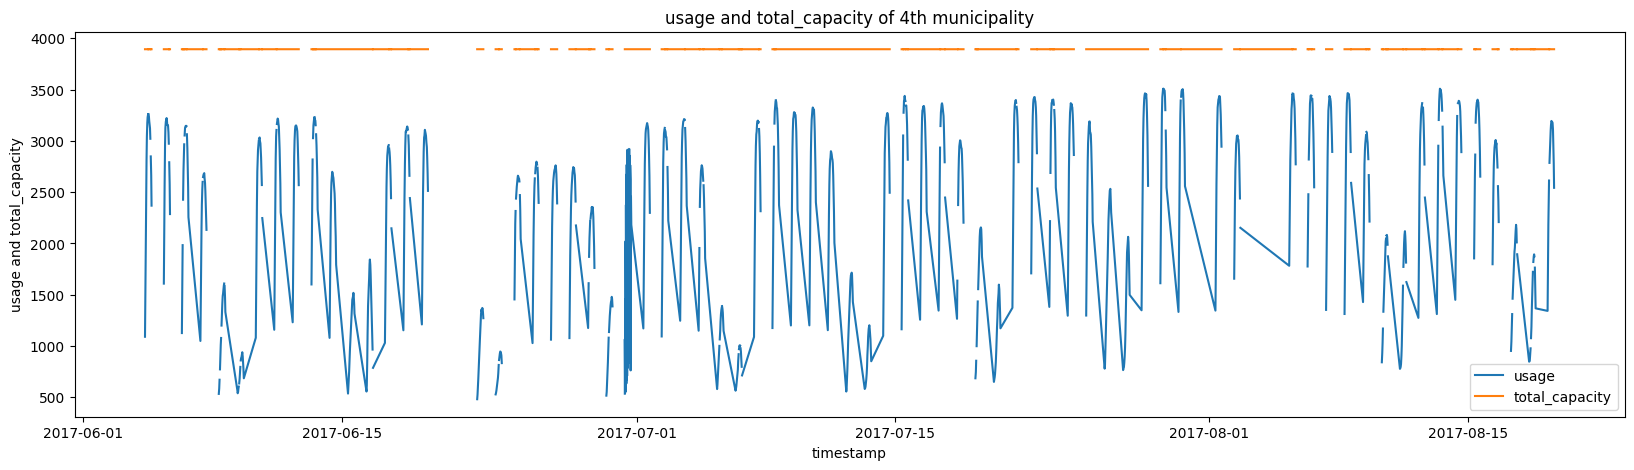

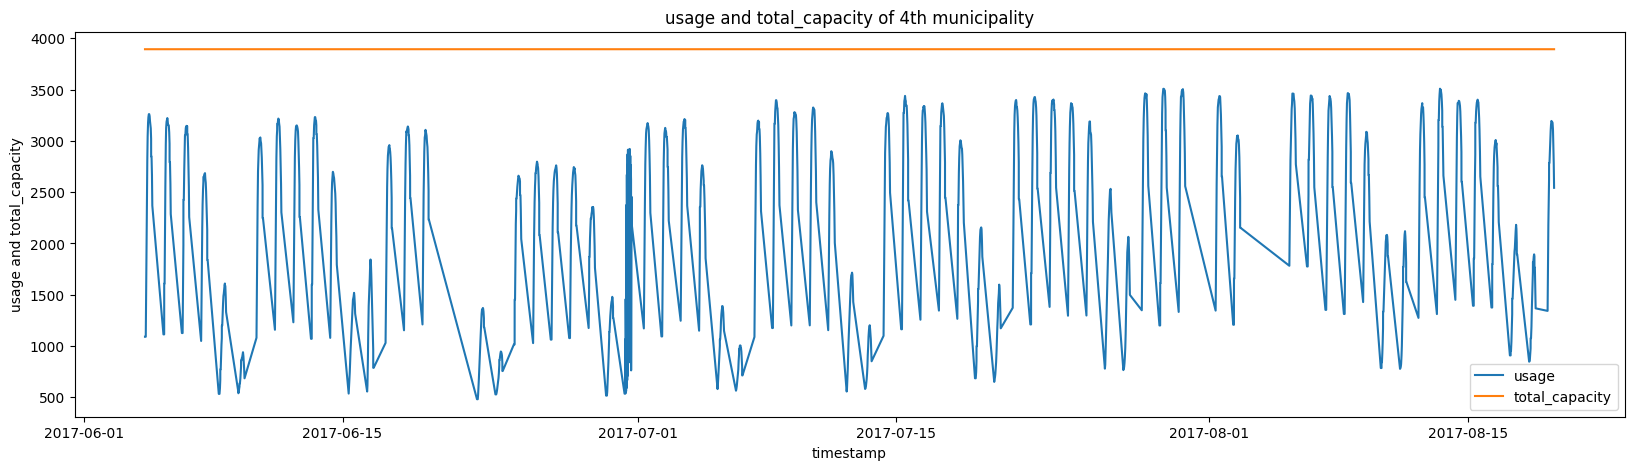

In [73]:
# plot usage and show missing values in 4th municipality
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(expanded_df['usage'], label='usage')
ax.plot(expanded_df['total_capacity'], label='total_capacity')
ax.legend()
ax.set_title('usage and total_capacity of 4th municipality')
ax.set_xlabel('timestamp')
ax.set_ylabel('usage and total_capacity')
plt.show()

# impute missing values for each municipality
imputed_df = expanded_df.copy()

# fill total_capacity with max value
imputed_df['total_capacity'] = imputed_df['total_capacity'].fillna(imputed_df['total_capacity'].max())

# fill usage with interpolation that is best appropriate of method
imputed_df['usage'] = imputed_df['usage'].fillna(method='bfill')
imputed_df['usage'] = imputed_df['usage'].fillna(method='ffill')

imputed_df['usage_percentage'] = imputed_df['usage']/imputed_df['total_capacity']*100

# plot usage and show missing values in 4th municipality
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(imputed_df['usage'], label='usage')
ax.plot(imputed_df['total_capacity'], label='total_capacity')
ax.legend()
ax.set_title('usage and total_capacity of 4th municipality')
ax.set_xlabel('timestamp')
ax.set_ylabel('usage and total_capacity')
plt.show()



In [74]:
df = imputed_df.copy()

## Preprocessing

In [75]:
# convert object to int
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['dayOfWeek'] = df['dayOfWeek'].astype(int)
df['day'] = df['day'].astype(int)
df['hour'] = df['hour'].astype(int)
df['minute'] = df['minute'].astype(int)
df['second'] = df['second'].astype(int)
df['quarter'] = df['quarter'].astype(int)
df['dayOfYear'] = df['dayOfYear'].astype(int)

In [76]:
# split data to train and test set
horizon = pd.to_datetime("2017-08-05")

train = df[df.date < horizon]
test = df[df.date >= horizon]

print(f"Shape of Dataframe: {df.shape}")
print(f"Shape of Train Set: {train.shape}")
print(f"Shape of Test Set: {test.shape}")

print(train.info())
print(test.info())

display(train.head())
display(test.head())

Shape of Dataframe: (1443, 14)
Shape of Train Set: (1138, 14)
Shape of Test Set: (305, 14)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1138 entries, 2017-06-04 07:00:00 to 2017-08-02 16:32:54
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   usage             1138 non-null   int64         
 1   total_capacity    1138 non-null   int64         
 2   date              1138 non-null   datetime64[ns]
 3   time              1138 non-null   object        
 4   year              1138 non-null   int64         
 5   month             1138 non-null   int64         
 6   dayOfWeek         1138 non-null   int64         
 7   day               1138 non-null   int64         
 8   hour              1138 non-null   int64         
 9   minute            1138 non-null   int64         
 10  second            1138 non-null   int64         
 11  quarter           1138 non-null   int64         
 12  dayOf

,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,
2017-06-04 07:00:00,1090,3893,2017-06-04,07:00:00,2017,6,6,4,7,0,0,2,155,27.998973
2017-06-04 07:59:42,1090,3893,2017-06-04,07:59:42,2017,6,6,4,7,59,42,2,155,27.998973
2017-06-04 08:25:42,1476,3893,2017-06-04,08:25:42,2017,6,6,4,8,25,42,2,155,37.914205
2017-06-04 08:59:42,2016,3893,2017-06-04,08:59:42,2017,6,6,4,8,59,42,2,155,51.785256
2017-06-04 09:32:46,2511,3893,2017-06-04,09:32:46,2017,6,6,4,9,32,46,2,155,64.500385


,usage,total_capacity,date,time,year,month,dayOfWeek,day,hour,minute,second,quarter,dayOfYear,usage_percentage
timestamp,,,,,,,,,,,,,,
2017-08-05 08:02:03,1782,3893,2017-08-05,08:02:03,2017,8,5,5,8,2,3,3,217,45.774467
2017-08-05 08:29:08,2132,3893,2017-08-05,08:29:08,2017,8,5,5,8,29,8,3,217,54.764963
2017-08-05 09:02:08,2558,3893,2017-08-05,09:02:08,2017,8,5,5,9,2,8,3,217,65.707680
2017-08-05 09:29:08,2814,3893,2017-08-05,09:29:08,2017,8,5,5,9,29,8,3,217,72.283586
2017-08-05 10:03:04,3011,3893,2017-08-05,10:03:04,2017,8,5,5,10,3,4,3,217,77.343951


## Model Development

### Forecast with XGBoost

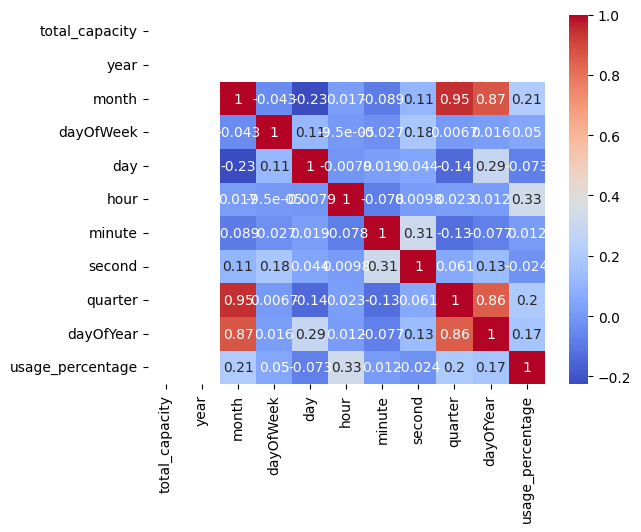

In [77]:
FEATURES = df.drop(columns=['usage', 'time', 'date']).columns
TARGET = 'usage'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# check the correlation between features
corr = X_train.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [78]:
#  xgboost model for each municipality
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

regressor = xgb.XGBRegressor(n_estimators=10000, learning_rate=0.001, n_jobs=7, random_state=42)
regressor.fit(X_train, y_train,
              early_stopping_rounds=50,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=100)


[0]	validation_0-rmse:2402.75451	validation_1-rmse:2592.44391
[100]	validation_0-rmse:2175.67060	validation_1-rmse:2349.84365
[200]	validation_0-rmse:1970.07190	validation_1-rmse:2130.35392
[300]	validation_0-rmse:1783.91755	validation_1-rmse:1931.28174
[400]	validation_0-rmse:1615.37371	validation_1-rmse:1750.91415
[500]	validation_0-rmse:1462.77133	validation_1-rmse:1587.60482
[600]	validation_0-rmse:1324.59737	validation_1-rmse:1439.64350
[700]	validation_0-rmse:1199.48081	validation_1-rmse:1305.46442
[800]	validation_0-rmse:1086.19266	validation_1-rmse:1183.15534
[900]	validation_0-rmse:983.60876	validation_1-rmse:1072.31992
[1000]	validation_0-rmse:890.71977	validation_1-rmse:971.72293
[1100]	validation_0-rmse:806.61028	validation_1-rmse:880.51567
[1200]	validation_0-rmse:730.44966	validation_1-rmse:797.82037
[1300]	validation_0-rmse:661.48624	validation_1-rmse:722.90005
[1400]	validation_0-rmse:599.03998	validation_1-rmse:655.05452
[1500]	validation_0-rmse:542.49586	validation_1-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=7, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

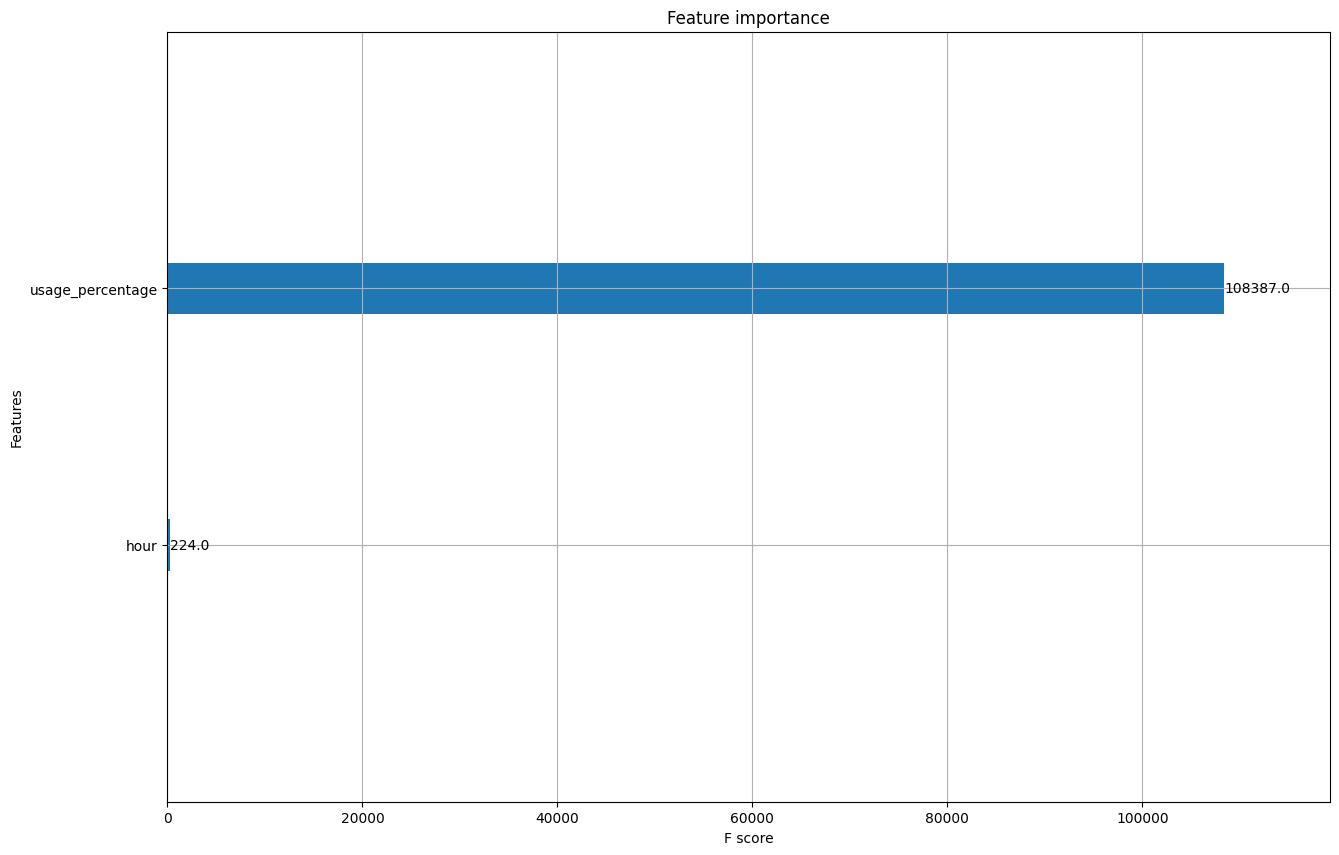

In [79]:
# plot feature importance
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_importance(regressor, ax=ax)
plt.show()


#### Forecast on Test Set

In [80]:
test['prediction'] = regressor.predict(X_test)
df = df.merge(test[['prediction']], left_index=True, right_index=True, how='left')

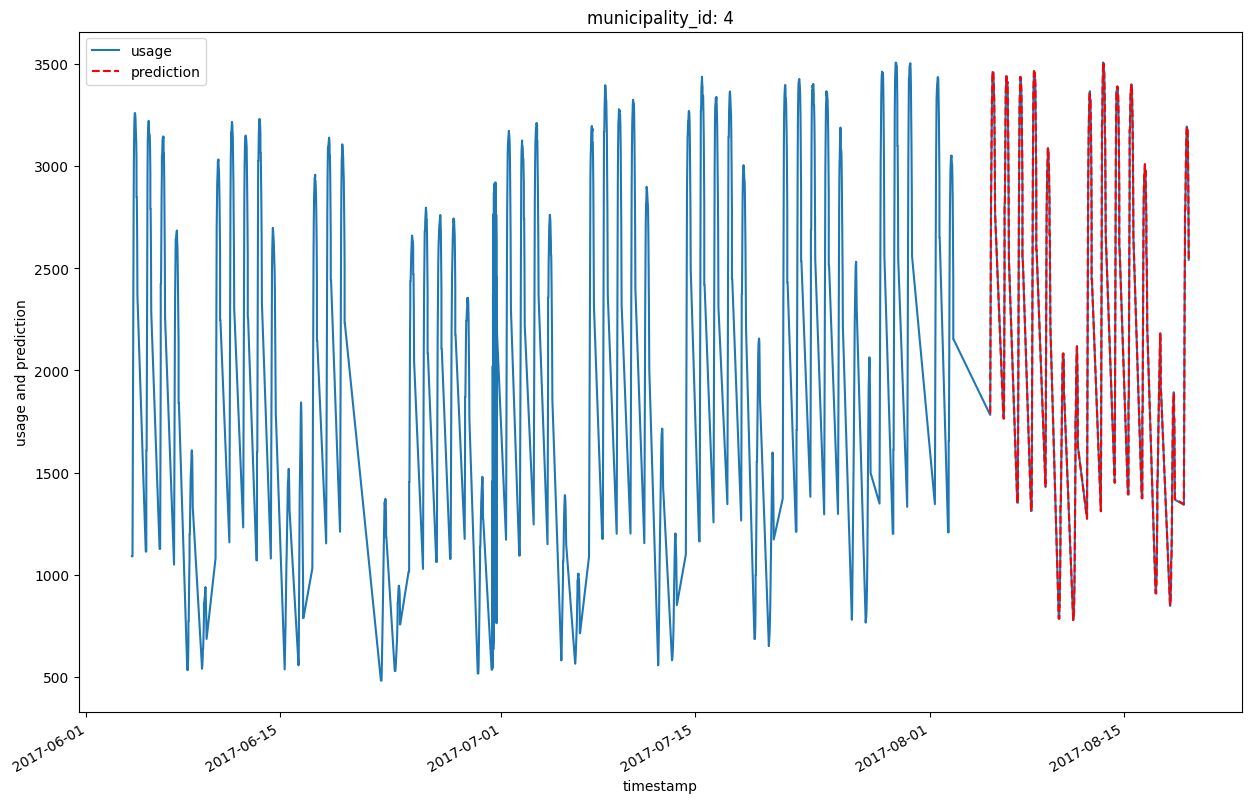

In [81]:
fig, ax = plt.subplots(figsize=(15, 10))
df['usage'].plot(ax=ax, label='usage')
df['prediction'].plot(ax=ax, label='prediction', color='red', linestyle='--')
ax.set_xlabel('timestamp')
ax.set_ylabel('usage and prediction')
ax.set_title(f"municipality_id: {selected_municipality_id}")
ax.legend()
plt.show()

In [83]:
# usage and prediction plot in plotly interactive
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['usage'], name='usage'))
fig.add_trace(go.Scatter(x=df.index, y=df['prediction'], name='prediction'))
fig.update_layout(title=f"municipality_id: {selected_municipality_id}", xaxis_title='timestamp', yaxis_title='usage and prediction')
fig.show()


### Evaluate Model

In [82]:
# calculate error metrics
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test['prediction'])}")
print(f"Mean Squared Error: {mean_squared_error(y_test, test['prediction'])}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, test['prediction']))}")
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, test['prediction'])}")

Mean Absolute Error: 1.7504010309938525
Mean Squared Error: 10.388684836152146
Root Mean Squared Error: 3.2231482801993683
Mean Absolute Percentage Error: 0.09051217287535808


In [84]:
# plot error metrics in plotly interactive
fig = go.Figure()

